In this notebook we do full fine-tuning of RoBERTa model. To find best hyperparameters we perform a grid search first.

# PREREQUISITES:

In [8]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from transformers import AutoTokenizer
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
from huggingface_hub import login
from sklearn.model_selection import ParameterGrid
from transformers import TrainerCallback
import matplotlib.pyplot as plt

In [5]:
login()

In [2]:
current_directory = os.getcwd() # get current directory
file_path = os.path.join(current_directory, '..', '..', 'data', 'processed', 'clean_data.csv') # navigate to folder with preprocessed data
data = pd.read_csv(file_path)

In [3]:
print(data.head(5))

                                        heading_text  bias_rating
0  chicago gun violence spikes and increasingly f...            0
1  'bullets just came from nowhere': fourth of ju...            1
2  dozens of shootings across us mark bloody july...            2
3  federal government will run out of cash on oct...            2
4  yellen tells congress that u.s. will run out o...            0


# Data splitting

In [22]:
X = data['heading_text'].values
y = data['bias_rating'].values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize data

In [24]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [25]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)

In [26]:
class NewsDataset(torch.utils.data.Dataset):
    """
    We need this class to manage and load
    encoded inputs and corresponding labels into a format compatible
    with PyTorch's DataLoader for model training and evaluation :)
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, y_train)
test_dataset = NewsDataset(test_encodings, y_test)


# Grid search

In [17]:
# function for calculating accuracy, precision, recall and f1 scores
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)  # get predicted class labels by selecting the highest score index
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
param_grid = {
    'learning_rate': [5e-5, 3e-5, 2e-5],
    'batch_size': [8, 16]
}

all_results = []

# loop over the hyperparameter grid
for params in ParameterGrid(param_grid):
    print(f"Training with learning rate: {params['learning_rate']} and batch size: {params['batch_size']}")

    # load the model
    model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

    # defining training arguments
    training_args = TrainingArguments(
        output_dir=f'./results_lr_{params["learning_rate"]}_bs_{params["batch_size"]}',
        num_train_epochs=3,
        per_device_train_batch_size=params["batch_size"],
        per_device_eval_batch_size=params["batch_size"],
        learning_rate=params["learning_rate"],
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_dir=f'./logs_lr_{params["learning_rate"]}_bs_{params["batch_size"]}',
        logging_steps=10,
        save_total_limit=2,
        load_best_model_at_end=True
    )

    # initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()

    metrics = trainer.evaluate(eval_dataset=test_dataset) # evaluate the model on the validation set
    metrics['learning_rate'] = params['learning_rate']
    metrics['batch_size'] = params['batch_size']
    all_results.append(metrics)

best_result = max(all_results, key=lambda x: x['eval_accuracy']) # report best hyperparameter combination
print(f"Best Hyperparameters: Learning Rate - {best_result['learning_rate']}, Batch Size - {best_result['batch_size']}")

# Evaluate model with the best hyperparameters

In [27]:
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Train the model

In [28]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [29]:
# a callback class to log metrics after each epoch and save them to a CSV file
class LogMetricsCallback(TrainerCallback):
    def __init__(self, log_dir, csv_filename="roberta_fine_tune.csv"):
        super().__init__()
        self.log_dir = log_dir
        self.csv_filepath = os.path.join(log_dir, csv_filename)
        
        # Ensure the log directory exists
        os.makedirs(log_dir, exist_ok=True)
        
        # Initialize CSV file with headers if it doesn't exist
        if not os.path.exists(self.csv_filepath):
            pd.DataFrame(columns=["epoch", "accuracy", "precision", "recall", "f1"]).to_csv(self.csv_filepath, index=False)

    def on_epoch_end(self, args, state, control, **kwargs):
        metrics = state.log_history[-1]  # Last entry should be the current epoch
        epoch = metrics.get("epoch")   # current epoch number
        accuracy = metrics.get("eval_accuracy")
        precision = metrics.get("eval_precision")
        recall = metrics.get("eval_recall")
        f1 = metrics.get("eval_f1")
        
        # add to CSV
        pd.DataFrame([{
            "epoch": epoch,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1
        }]).to_csv(self.csv_filepath, mode='a', header=False, index=False)
        
        print(f"Metrics for epoch {epoch} saved to {self.csv_filepath}")


In [ ]:
# Define training arguments for full fine-tuning
training_args = TrainingArguments(
    output_dir='./roberta_finetune',
    per_device_train_batch_size=8,  # batch size found in grid search  
    per_device_eval_batch_size=8,   # batch size found in grid search  
    num_train_epochs=10,                
    evaluation_strategy="epoch",
    save_strategy="epoch", 
    logging_dir='./roberta_finetune',  
    logging_steps=10,            
    learning_rate=2e-5,     # lr found in grid search     
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",  # monitor eval_loss for early stopping
    greater_is_better=False
)

# Set up log directory for metrics
log_dir = os.path.join(os.getcwd(), '..', '..', 'results')

# Initialize Trainer for full fine-tuning with early stopping
trainer = Trainer(
    model=model,           
    args=training_args,              
    train_dataset=train_dataset,  
    eval_dataset=test_dataset,      
    compute_metrics=compute_metrics,
    callbacks=[
        LogMetricsCallback(log_dir=log_dir),
        EarlyStoppingCallback(early_stopping_patience=0)
    ]
)

# Start training
trainer.train()

# Accuracy of the model

In [22]:
metrics = trainer.evaluate()
print(f"Test Accuracy: {metrics['eval_accuracy']}")

Epoch,Training Loss,Validation Loss,Accuracy
0,No log,0.881688,0.641527


Test Accuracy: 0.6415267877673029


# Train and Test loss graph

In [17]:
file_path = os.path.join(current_directory, '..', '..', 'results', 'roberta_fine_tuning.csv') # navigate to folder with results
data_to_plot = pd.read_csv(file_path)
print(data_to_plot.head(3))

   Epoch  Training Loss  Validation Loss  Accuracy  Precision    Recall  \
0      1         0.8638         0.899698  0.590021   0.605249  0.590021   
1      2         0.7676         0.859747  0.607496   0.613800  0.607496   
2      3         0.5320         0.746042  0.623592   0.591021  0.623592   

         F1  
0  0.576725  
1  0.593004  
2  0.615255  


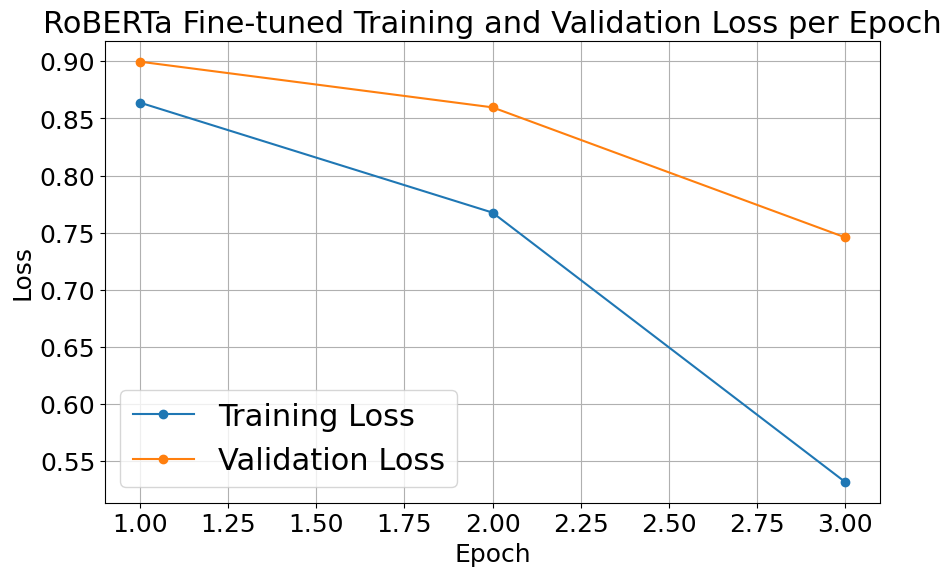

In [24]:
# plot train test losses

plt.figure(figsize=(10, 6))
plt.plot(data_to_plot['Epoch'], data_to_plot['Training Loss'], label='Training Loss', marker='o')
plt.plot(data_to_plot['Epoch'], data_to_plot['Validation Loss'], label='Validation Loss', marker='o')
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.title("RoBERTa Fine-tuned Training and Validation Loss per Epoch", fontsize=22)

# Set legend font size
plt.legend(fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.grid(True)
plt.show()